# Gradient Bandit Algorithms

In [4]:
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

In [6]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## The 10-armed Testbed

In [72]:
key = random.PRNGKey(31415)

key_bandit, key_sample = random.split(key, 2)
n_bandits = 10
true_values = random.normal(key_bandit, (n_bandits,)) + 4
true_values

DeviceArray([4.099875 , 3.787432 , 5.4521613, 3.1889436, 3.1070209,
             4.612499 , 2.1670017, 4.21462  , 3.1789415, 4.383062 ],            dtype=float32)

In [73]:
n_samples = 5000
bandit_samples = random.normal(key_sample, (n_bandits, n_samples)) + true_values[:, None]
bandit_samples.shape

(10, 5000)

In [74]:
bandit_samples = pd.DataFrame(bandit_samples.T).melt()
bandit_samples = bandit_samples.rename({"variable":"action", "value":"reward"}, axis=1)

<AxesSubplot:xlabel='action', ylabel='reward'>

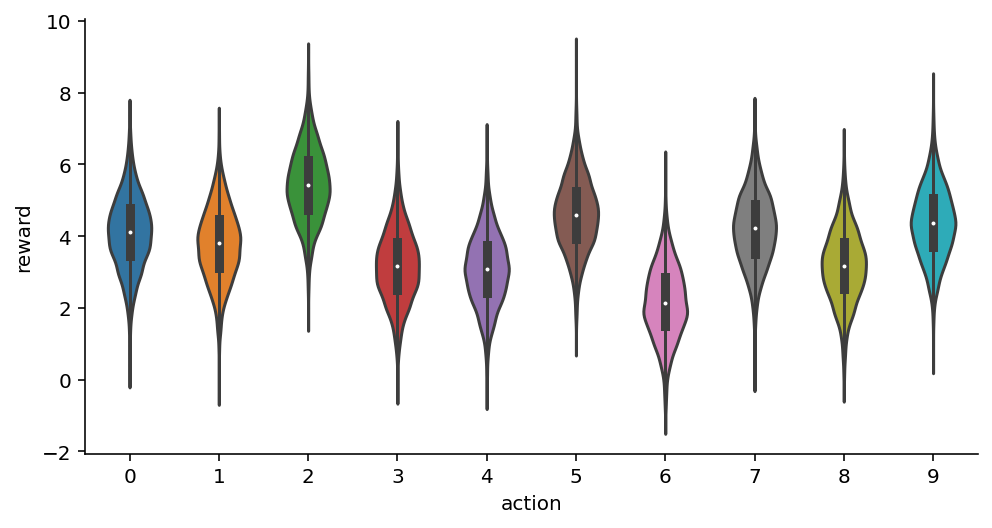

In [76]:
plt.subplots(figsize=(8, 4))
sns.violinplot(x="action", y="reward", data=bandit_samples, width=0.5)

## Gradient bandit

$$
    \pi_t(a) := \frac{\exp(H_t(a))}{\sum_{b=1}^K\exp(H_t(b))}
$$

In [78]:
num_steps = 1000
bandits = jnp.arange(n_bandits)
key_step = random.PRNGKey(3141)

In [103]:
def take(state, key, alpha, has_baseline=True):
    num_visits, action_preferences, cumulative_rewards = state
    key_action, key_reward = random.split(key, 2)
    
    average_reward = cumulative_rewards / jnp.maximum(num_visits, 1)
    
    relative_preference = jax.nn.softmax(action_preferences)
    action = random.choice(key_action, bandits, p=relative_preference)
    reward = random.normal(key_reward) + true_values[action.astype(int)]
    
    # one-hot-encoded
    action_ohe = jax.nn.one_hot(action, n_bandits)
    
    baseline_comparisson = reward - average_reward * has_baseline
    action_update = action_preferences + alpha * baseline_comparisson * (1 - relative_preference)
    comp_action_update = action_preferences - alpha * baseline_comparisson * relative_preference
    
    action_preferences = action_update * action_ohe + comp_action_update * (1 - action_ohe)
    num_visits = num_visits + action_ohe
    cumulative_rewards = cumulative_rewards + action_ohe * reward
    
    return (num_visits, action_preferences, cumulative_rewards), (reward, action)


def gradient_learn(key, alpha, num_steps, init_rewards, has_baseline=True):
    keys = random.split(key, num_steps)
    take_alpha = partial(take, alpha=alpha, has_baseline=has_baseline)
    
    num_visits = jnp.zeros_like(init_rewards)
    action_preferences = jnp.zeros_like(init_rewards)
    
    init_state = (num_visits, action_preferences, init_rewards)
    state_res, (reward_hist, action_hist) = jax.lax.scan(take_alpha, init_state, keys)
    (num_visits, action_preferences, cumulative_rewards) = state_res
    return (num_visits, action_preferences, cumulative_rewards), (reward_hist, action_hist)


# Note: 
# 1. vmap (0, 0, None, None) is not the same as 'vmapping'
# 2. first over (0, None, None, None) and then over (None, 0, None, None).
# The behaviour of 1. is one-to-one, the behaviour of 2. is cross-product

# vmap over keys for multiple samples
gradient_learn_vmap = jax.vmap(gradient_learn, (0, None, None, None, None))
# vmap over alpha for multiple configurations
gradient_learn_vmap = jax.vmap(gradient_learn_vmap, (None, 0, None, None, None))
# vmap over baseline 
gradient_learn_vmap = jax.vmap(gradient_learn_vmap, (None, None, None, None, 0))

In [106]:
nsims = 2000
num_steps = 1000

key = random.PRNGKey(314)
keys = random.split(key, nsims)
alpha_values = jnp.array([0.01, 0.1, 0.4])
init_rewards = jnp.zeros(n_bandits)
baseline = jnp.array([True, False])

_, (reward_sims_multiple, action_sims_multiple) = gradient_learn_vmap(keys, alpha_values, num_steps, init_rewards, baseline)

In [108]:
baseline_sims = reward_sims_multiple[0]
no_baseline_sims = reward_sims_multiple[1]

In [116]:
baseline_sims.shape

(3, 2000, 1000)

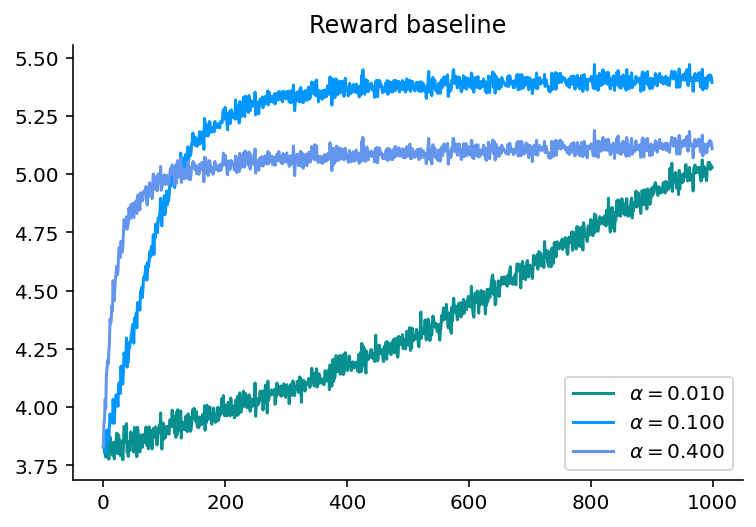

In [158]:
colors_baseline = ["#088F8F", "#0096FF", "#6495ED"]
for sim, c in zip(baseline_sims, colors_baseline):
    plt.plot(sim.mean(axis=0), color=c)

plt.title("Reward baseline")
legends = [r"$\alpha=$"f"{alpha:0.3f}" for alpha in alpha_values]
plt.legend(legends);

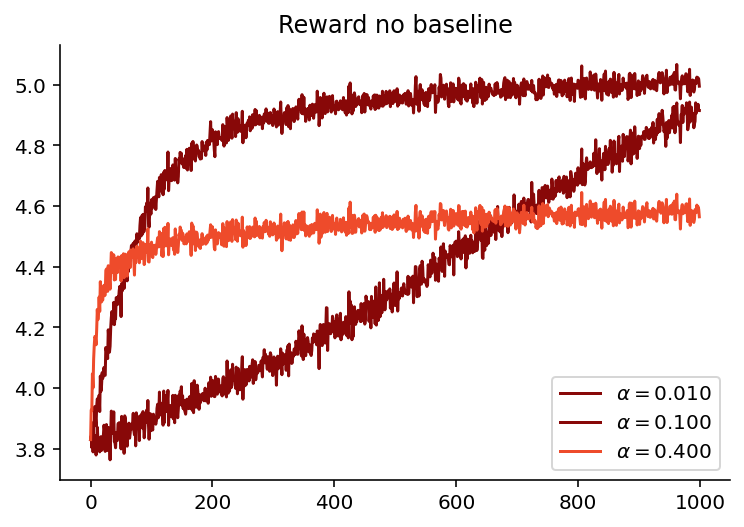

In [157]:
colors_no_baseline = ["#880808", "#880808", "#EE4B2B"]
for sim, c in zip(no_baseline_sims, colors_no_baseline):
    plt.plot(sim.mean(axis=0), color=c)

plt.title("Reward no baseline")
legends = [r"$\alpha=$"f"{alpha:0.3f}" for alpha in alpha_values]
plt.legend(legends);

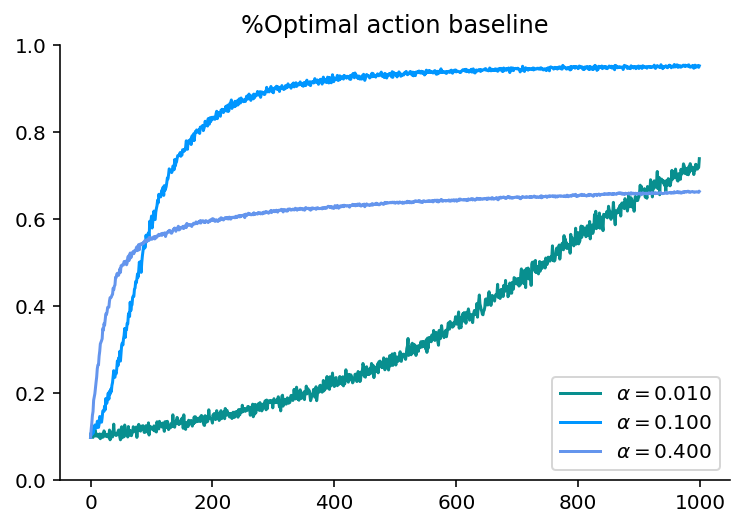

In [154]:
plt.title("%Optimal action baseline")
baseline_correct = (action_sims_multiple[0] == true_values.argmax()).mean(axis=1)
for sim, c in zip(baseline_correct, colors_baseline):
    plt.plot(sim, c=c)
legends = [r"$\alpha=$"f"{alpha:0.3f}" for alpha in alpha_values]
plt.ylim(0, 1)
plt.legend(legends);

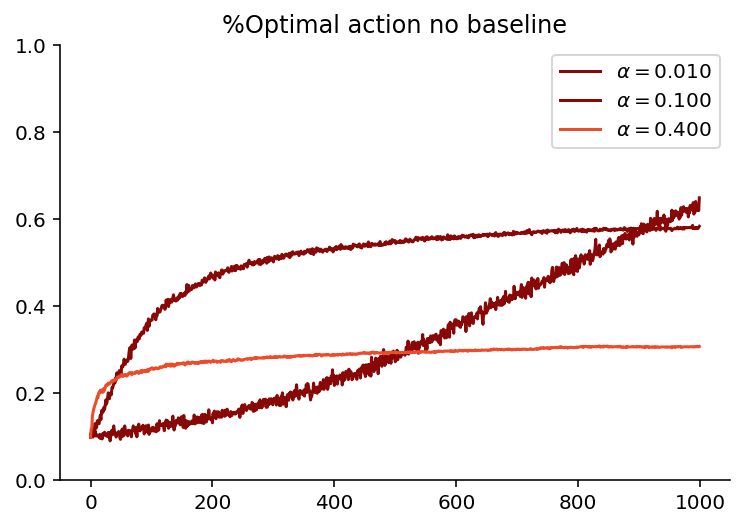

In [156]:
plt.title("%Optimal action no baseline")
no_baseline_correct = (action_sims_multiple[1] == true_values.argmax()).mean(axis=1)
for sim, c in zip(no_baseline_correct, colors_no_baseline):
    plt.plot(sim, c=c)
legends = [r"$\alpha=$"f"{alpha:0.3f}" for alpha in alpha_values]
plt.ylim(0, 1)
plt.legend(legends);